In [1]:
import os
os.chdir( "../")

In [2]:
import pandas as pd
import numpy as np

path = "Dataset/data_train.csv"
df = pd.read_csv(filepath_or_buffer=path,
                               sep=",",
                               header=1,
                               engine='python',
                               names=['UserID', 'ItemID', 'Interaction'])


df

,UserID,ItemID,Interaction
0,1,15,1.0
1,1,16,1.0
2,1,133,1.0
3,1,161,1.0
4,1,187,1.0
...,...,...,...
478724,13024,13605,1.0
478725,13024,13823,1.0
478726,13024,15122,1.0
478727,13024,18185,1.0


In [3]:
df.Interaction.value_counts()

1.0    478729
Name: Interaction, dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478729 entries, 0 to 478728
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   UserID       478729 non-null  int64  
 1   ItemID       478729 non-null  int64  
 2   Interaction  478729 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 11.0 MB


In [5]:
user_ids = df["UserID"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
item_ids = df["ItemID"].unique().tolist()
item2item_encoded = {x: i for i, x in enumerate(item_ids)}
item_encoded2item = {i: x for i, x in enumerate(item_ids)}
df["User"] = df["UserID"].map(user2user_encoded)
df["Item"] = df["ItemID"].map(item2item_encoded)

num_users = len(user2user_encoded)
num_items = len(item_encoded2item)
df["Interaction"] = df["Interaction"].values.astype(np.float32)

# min and max ratings will be used to normalize the ratings later
min_rating = 0.0
max_rating = max(df["Interaction"])

print(
    "Number of users: {}, Number of Items: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_items, min_rating, max_rating
    )
)

Number of users: 12638, Number of Items: 22222, Min rating: 0.0, Max rating: 1.0


In [6]:
df.head()

,UserID,ItemID,Interaction,User,Item
0,1,15,1.0,0,0
1,1,16,1.0,0,1
2,1,133,1.0,0,2
3,1,161,1.0,0,3
4,1,187,1.0,0,4


In [7]:
userId_unique = df["UserID"].unique()
itemId_unique = df["ItemID"].unique()

In [8]:
from sklearn.model_selection import train_test_split
import numpy as np
import scipy.sparse as sps
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample



urm_all = sps.coo_matrix((df["Interaction"].values, 
                          (df["User"].values, df["Item"].values)))

urm_train_validation, urm_test = split_train_in_two_percentage_global_sample(urm_all, train_percentage = 0.80)
urm_train, urm_validation = split_train_in_two_percentage_global_sample(urm_train_validation, train_percentage = 0.80)

In [9]:
num_users = len(userId_unique)
num_items = len(itemId_unique)

In [10]:
from Recommenders.Recommender_import_list import *
from Evaluation.Evaluator import EvaluatorHoldout
evaluator_validation = EvaluatorHoldout(urm_validation, cutoff_list=[10], ignore_users=[])

2023-12-08 21:50:16.361740: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-12-08 21:50:16.361772: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


EvaluatorHoldout: Ignoring 2602 (20.6%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 0 Users


## Insert model here

In [11]:
model = SLIMElasticNetRecommender

In [12]:
import optuna as op

def objective(trial):
    topK = trial.suggest_int("topK", 5, 1e4)
    l1 = trial.suggest_float("l1_ratio", 0.01, 0.1)
    alpha = trial.suggest_float("alpha", 5e-4, 0.015)

    
    recommender = model(urm_train)
    recommender.fit(**trial.params)
    
    result, _ = evaluator_validation.evaluateRecommender(recommender)
    MAP_result = result["MAP"].item()
       
    return MAP_result

In [13]:
best_params = {'topK': 6658, 'l1_ratio': 0.03659854387723134, 'alpha': 0.0012812054186341782}

study = op.create_study(direction="maximize")
study.enqueue_trial(best_params)
study.optimize(objective, n_trials=30)

[I 2023-12-08 21:50:17,058] A new study created in memory with name: no-name-d9c464ce-f0b9-4a83-87f3-17e79394a277


SLIMElasticNetRecommender: URM Detected 472 ( 3.7%) users with no interactions.
SLIMElasticNetRecommender: URM Detected 341 ( 1.5%) items with no interactions.
SLIMElasticNetRecommender: Processed 22222 (100.0%) in 4.70 min. Items per second: 78.77
EvaluatorHoldout: Processed 10036 (100.0%) in 4.14 sec. Users per second: 2423


[I 2023-12-08 21:55:03,404] Trial 0 finished with value: 0.030350606862912768 and parameters: {'topK': 6658, 'l1_ratio': 0.03659854387723134, 'alpha': 0.0012812054186341782}. Best is trial 0 with value: 0.030350606862912768.


SLIMElasticNetRecommender: URM Detected 472 ( 3.7%) users with no interactions.
SLIMElasticNetRecommender: URM Detected 341 ( 1.5%) items with no interactions.
SLIMElasticNetRecommender: Processed 22222 (100.0%) in 3.23 min. Items per second: 114.76
EvaluatorHoldout: Processed 10036 (100.0%) in 3.64 sec. Users per second: 2758


[I 2023-12-08 21:58:20,704] Trial 1 finished with value: 0.02906733774285613 and parameters: {'topK': 3514, 'l1_ratio': 0.013354560969564262, 'alpha': 0.006938764253189523}. Best is trial 0 with value: 0.030350606862912768.


SLIMElasticNetRecommender: URM Detected 472 ( 3.7%) users with no interactions.
SLIMElasticNetRecommender: URM Detected 341 ( 1.5%) items with no interactions.
SLIMElasticNetRecommender: Processed 22222 (100.0%) in 1.29 min. Items per second: 287.77
EvaluatorHoldout: Processed 10036 (100.0%) in 2.08 sec. Users per second: 4833


[I 2023-12-08 21:59:40,009] Trial 2 finished with value: 0.023889790405334496 and parameters: {'topK': 5332, 'l1_ratio': 0.08132070408882985, 'alpha': 0.0142125315357285}. Best is trial 0 with value: 0.030350606862912768.


SLIMElasticNetRecommender: URM Detected 472 ( 3.7%) users with no interactions.
SLIMElasticNetRecommender: URM Detected 341 ( 1.5%) items with no interactions.
SLIMElasticNetRecommender: Processed 22222 (100.0%) in 1.37 min. Items per second: 270.78
EvaluatorHoldout: Processed 10036 (100.0%) in 2.17 sec. Users per second: 4623


[I 2023-12-08 22:01:04,254] Trial 3 finished with value: 0.025649135335016216 and parameters: {'topK': 4398, 'l1_ratio': 0.0749556048097358, 'alpha': 0.009843294472264216}. Best is trial 0 with value: 0.030350606862912768.


SLIMElasticNetRecommender: URM Detected 472 ( 3.7%) users with no interactions.
SLIMElasticNetRecommender: URM Detected 341 ( 1.5%) items with no interactions.
SLIMElasticNetRecommender: Processed 22222 (100.0%) in 1.49 min. Items per second: 248.93
EvaluatorHoldout: Processed 10036 (100.0%) in 2.38 sec. Users per second: 4215


[I 2023-12-08 22:02:35,912] Trial 4 finished with value: 0.027257832121821958 and parameters: {'topK': 3152, 'l1_ratio': 0.09440942428811702, 'alpha': 0.005197731341448514}. Best is trial 0 with value: 0.030350606862912768.


SLIMElasticNetRecommender: URM Detected 472 ( 3.7%) users with no interactions.
SLIMElasticNetRecommender: URM Detected 341 ( 1.5%) items with no interactions.
SLIMElasticNetRecommender: Processed 22222 (100.0%) in 1.31 min. Items per second: 282.47
EvaluatorHoldout: Processed 10036 (100.0%) in 2.05 sec. Users per second: 4884


[I 2023-12-08 22:03:56,645] Trial 5 finished with value: 0.024733443729557738 and parameters: {'topK': 2454, 'l1_ratio': 0.08764339451681392, 'alpha': 0.010941054775456953}. Best is trial 0 with value: 0.030350606862912768.


SLIMElasticNetRecommender: URM Detected 472 ( 3.7%) users with no interactions.
SLIMElasticNetRecommender: URM Detected 341 ( 1.5%) items with no interactions.
SLIMElasticNetRecommender: Processed 22222 (100.0%) in 1.48 min. Items per second: 250.36
EvaluatorHoldout: Processed 10036 (100.0%) in 2.31 sec. Users per second: 4345


[I 2023-12-08 22:05:27,720] Trial 6 finished with value: 0.02740422969373767 and parameters: {'topK': 1758, 'l1_ratio': 0.09598938688094757, 'alpha': 0.004984415540150881}. Best is trial 0 with value: 0.030350606862912768.


SLIMElasticNetRecommender: URM Detected 472 ( 3.7%) users with no interactions.
SLIMElasticNetRecommender: URM Detected 341 ( 1.5%) items with no interactions.
SLIMElasticNetRecommender: Processed 22222 (100.0%) in 1.39 min. Items per second: 267.25
EvaluatorHoldout: Processed 10036 (100.0%) in 2.21 sec. Users per second: 4532


[I 2023-12-08 22:06:53,093] Trial 7 finished with value: 0.025963191241688693 and parameters: {'topK': 6341, 'l1_ratio': 0.06216863114894521, 'alpha': 0.010385780988454885}. Best is trial 0 with value: 0.030350606862912768.


SLIMElasticNetRecommender: URM Detected 472 ( 3.7%) users with no interactions.
SLIMElasticNetRecommender: URM Detected 341 ( 1.5%) items with no interactions.
SLIMElasticNetRecommender: Processed 22222 (100.0%) in 1.35 min. Items per second: 274.41
EvaluatorHoldout: Processed 10036 (100.0%) in 2.13 sec. Users per second: 4705


[I 2023-12-08 22:08:16,214] Trial 8 finished with value: 0.025097154213086868 and parameters: {'topK': 6675, 'l1_ratio': 0.0654772951938739, 'alpha': 0.012706838777620846}. Best is trial 0 with value: 0.030350606862912768.


SLIMElasticNetRecommender: URM Detected 472 ( 3.7%) users with no interactions.
SLIMElasticNetRecommender: URM Detected 341 ( 1.5%) items with no interactions.
SLIMElasticNetRecommender: Processed 22222 (100.0%) in 1.33 min. Items per second: 278.08
EvaluatorHoldout: Processed 10036 (100.0%) in 2.12 sec. Users per second: 4739


[I 2023-12-08 22:09:38,251] Trial 9 finished with value: 0.02487350696223754 and parameters: {'topK': 4958, 'l1_ratio': 0.06250181690989377, 'alpha': 0.013880115384293018}. Best is trial 0 with value: 0.030350606862912768.


SLIMElasticNetRecommender: URM Detected 472 ( 3.7%) users with no interactions.
SLIMElasticNetRecommender: URM Detected 341 ( 1.5%) items with no interactions.
SLIMElasticNetRecommender: Processed 22222 (100.0%) in 4.90 min. Items per second: 75.58
EvaluatorHoldout: Processed 10036 (100.0%) in 3.76 sec. Users per second: 2667


[I 2023-12-08 22:14:36,091] Trial 10 finished with value: 0.028569099653944354 and parameters: {'topK': 8992, 'l1_ratio': 0.03805315309816465, 'alpha': 0.0005364193438929381}. Best is trial 0 with value: 0.030350606862912768.


SLIMElasticNetRecommender: URM Detected 472 ( 3.7%) users with no interactions.
SLIMElasticNetRecommender: URM Detected 341 ( 1.5%) items with no interactions.
SLIMElasticNetRecommender: Processed 22222 (100.0%) in 4.85 min. Items per second: 76.30
EvaluatorHoldout: Processed 10036 (100.0%) in 3.67 sec. Users per second: 2731


[I 2023-12-08 22:19:31,055] Trial 11 finished with value: 0.027367556162892975 and parameters: {'topK': 457, 'l1_ratio': 0.010525401924705616, 'alpha': 0.000586462596996724}. Best is trial 0 with value: 0.030350606862912768.


SLIMElasticNetRecommender: URM Detected 472 ( 3.7%) users with no interactions.
SLIMElasticNetRecommender: URM Detected 341 ( 1.5%) items with no interactions.
SLIMElasticNetRecommender: Processed 22222 (100.0%) in 2.99 min. Items per second: 123.88
EvaluatorHoldout: Processed 10036 (100.0%) in 3.55 sec. Users per second: 2826


[I 2023-12-08 22:22:33,996] Trial 12 finished with value: 0.028925273776310278 and parameters: {'topK': 7968, 'l1_ratio': 0.02406984455932995, 'alpha': 0.00616091476448747}. Best is trial 0 with value: 0.030350606862912768.


SLIMElasticNetRecommender: URM Detected 472 ( 3.7%) users with no interactions.
SLIMElasticNetRecommender: URM Detected 341 ( 1.5%) items with no interactions.
SLIMElasticNetRecommender: Processed 22222 (100.0%) in 3.30 min. Items per second: 112.20
EvaluatorHoldout: Processed 10036 (100.0%) in 3.72 sec. Users per second: 2699


[I 2023-12-08 22:25:55,790] Trial 13 finished with value: 0.030078400298607737 and parameters: {'topK': 9888, 'l1_ratio': 0.04272987115688922, 'alpha': 0.002584487088098839}. Best is trial 0 with value: 0.030350606862912768.


SLIMElasticNetRecommender: URM Detected 472 ( 3.7%) users with no interactions.
SLIMElasticNetRecommender: URM Detected 341 ( 1.5%) items with no interactions.
SLIMElasticNetRecommender: Processed 22222 (100.0%) in 3.12 min. Items per second: 118.58
EvaluatorHoldout: Processed 10036 (100.0%) in 3.45 sec. Users per second: 2913


[I 2023-12-08 22:29:06,654] Trial 14 finished with value: 0.029846556365338995 and parameters: {'topK': 9891, 'l1_ratio': 0.04608834237509274, 'alpha': 0.0030415521873475}. Best is trial 0 with value: 0.030350606862912768.


SLIMElasticNetRecommender: URM Detected 472 ( 3.7%) users with no interactions.
SLIMElasticNetRecommender: URM Detected 341 ( 1.5%) items with no interactions.
SLIMElasticNetRecommender: Processed 22222 (100.0%) in 3.17 min. Items per second: 116.83
EvaluatorHoldout: Processed 10036 (100.0%) in 3.68 sec. Users per second: 2730


[I 2023-12-08 22:32:20,560] Trial 15 finished with value: 0.02998714548261197 and parameters: {'topK': 8237, 'l1_ratio': 0.04061550347212515, 'alpha': 0.0029717833320338826}. Best is trial 0 with value: 0.030350606862912768.


SLIMElasticNetRecommender: URM Detected 472 ( 3.7%) users with no interactions.
SLIMElasticNetRecommender: URM Detected 341 ( 1.5%) items with no interactions.
SLIMElasticNetRecommender: Processed 22222 (100.0%) in 3.03 min. Items per second: 122.08
EvaluatorHoldout: Processed 10036 (100.0%) in 3.37 sec. Users per second: 2974


[I 2023-12-08 22:35:25,983] Trial 16 finished with value: 0.029844729608330886 and parameters: {'topK': 6743, 'l1_ratio': 0.05141621295159214, 'alpha': 0.002866305328998001}. Best is trial 0 with value: 0.030350606862912768.


SLIMElasticNetRecommender: URM Detected 472 ( 3.7%) users with no interactions.
SLIMElasticNetRecommender: URM Detected 341 ( 1.5%) items with no interactions.
SLIMElasticNetRecommender: Processed 22222 (100.0%) in 1.75 min. Items per second: 211.89
EvaluatorHoldout: Processed 10036 (100.0%) in 2.68 sec. Users per second: 3746


[I 2023-12-08 22:37:13,550] Trial 17 finished with value: 0.02758984718505456 and parameters: {'topK': 9765, 'l1_ratio': 0.03416799917683733, 'alpha': 0.008650173085638986}. Best is trial 0 with value: 0.030350606862912768.


SLIMElasticNetRecommender: URM Detected 472 ( 3.7%) users with no interactions.
SLIMElasticNetRecommender: URM Detected 341 ( 1.5%) items with no interactions.
SLIMElasticNetRecommender: Processed 22222 (100.0%) in 4.11 min. Items per second: 90.17
EvaluatorHoldout: Processed 10036 (100.0%) in 4.19 sec. Users per second: 2395


[I 2023-12-08 22:41:24,251] Trial 18 finished with value: 0.030364252184200514 and parameters: {'topK': 7765, 'l1_ratio': 0.029537380631026046, 'alpha': 0.0018328668672485519}. Best is trial 18 with value: 0.030364252184200514.


SLIMElasticNetRecommender: URM Detected 472 ( 3.7%) users with no interactions.
SLIMElasticNetRecommender: URM Detected 341 ( 1.5%) items with no interactions.
SLIMElasticNetRecommender: Processed 22222 (100.0%) in 2.99 min. Items per second: 123.95
EvaluatorHoldout: Processed 10036 (100.0%) in 3.43 sec. Users per second: 2922


[I 2023-12-08 22:44:26,983] Trial 19 finished with value: 0.029471189432329545 and parameters: {'topK': 7753, 'l1_ratio': 0.02945100973806623, 'alpha': 0.004415254405983738}. Best is trial 18 with value: 0.030364252184200514.


SLIMElasticNetRecommender: URM Detected 472 ( 3.7%) users with no interactions.
SLIMElasticNetRecommender: URM Detected 341 ( 1.5%) items with no interactions.
SLIMElasticNetRecommender: Processed 22222 (100.0%) in 4.34 min. Items per second: 85.39
EvaluatorHoldout: Processed 10036 (100.0%) in 4.13 sec. Users per second: 2430


[I 2023-12-08 22:48:51,438] Trial 20 finished with value: 0.03018204701171038 and parameters: {'topK': 5870, 'l1_ratio': 0.023843980200383745, 'alpha': 0.0014224119992607095}. Best is trial 18 with value: 0.030364252184200514.


SLIMElasticNetRecommender: URM Detected 472 ( 3.7%) users with no interactions.
SLIMElasticNetRecommender: URM Detected 341 ( 1.5%) items with no interactions.
SLIMElasticNetRecommender: Processed 22222 (100.0%) in 4.30 min. Items per second: 86.18
EvaluatorHoldout: Processed 10036 (100.0%) in 4.16 sec. Users per second: 2414


[I 2023-12-08 22:53:13,539] Trial 21 finished with value: 0.030288129400823864 and parameters: {'topK': 5845, 'l1_ratio': 0.024161637287600665, 'alpha': 0.0015273482639684092}. Best is trial 18 with value: 0.030364252184200514.


SLIMElasticNetRecommender: URM Detected 472 ( 3.7%) users with no interactions.
SLIMElasticNetRecommender: URM Detected 341 ( 1.5%) items with no interactions.
SLIMElasticNetRecommender: Processed 22222 (100.0%) in 4.17 min. Items per second: 88.85
EvaluatorHoldout: Processed 10036 (100.0%) in 4.02 sec. Users per second: 2497


[I 2023-12-08 22:57:27,725] Trial 22 finished with value: 0.030332232534305215 and parameters: {'topK': 7372, 'l1_ratio': 0.029209768256168757, 'alpha': 0.0017685828320574315}. Best is trial 18 with value: 0.030364252184200514.


SLIMElasticNetRecommender: URM Detected 472 ( 3.7%) users with no interactions.
SLIMElasticNetRecommender: URM Detected 341 ( 1.5%) items with no interactions.
SLIMElasticNetRecommender: Processed 22222 (100.0%) in 3.00 min. Items per second: 123.34
EvaluatorHoldout: Processed 10036 (100.0%) in 3.49 sec. Users per second: 2876


[I 2023-12-08 23:00:31,397] Trial 23 finished with value: 0.02957206437776406 and parameters: {'topK': 7428, 'l1_ratio': 0.032755713421323336, 'alpha': 0.004012043237783244}. Best is trial 18 with value: 0.030364252184200514.


SLIMElasticNetRecommender: URM Detected 472 ( 3.7%) users with no interactions.
SLIMElasticNetRecommender: URM Detected 341 ( 1.5%) items with no interactions.
SLIMElasticNetRecommender: Processed 22222 (100.0%) in 3.15 min. Items per second: 117.57
EvaluatorHoldout: Processed 10036 (100.0%) in 3.43 sec. Users per second: 2927


[I 2023-12-08 23:03:43,852] Trial 24 finished with value: 0.030236663883037182 and parameters: {'topK': 8791, 'l1_ratio': 0.047466078762258404, 'alpha': 0.0019212278832024285}. Best is trial 18 with value: 0.030364252184200514.


SLIMElasticNetRecommender: URM Detected 472 ( 3.7%) users with no interactions.
SLIMElasticNetRecommender: URM Detected 341 ( 1.5%) items with no interactions.
SLIMElasticNetRecommender: Processed 22222 (100.0%) in 2.97 min. Items per second: 124.62
EvaluatorHoldout: Processed 10036 (100.0%) in 3.50 sec. Users per second: 2866


[I 2023-12-08 23:06:45,690] Trial 25 finished with value: 0.029603550235027084 and parameters: {'topK': 7117, 'l1_ratio': 0.03828745720034756, 'alpha': 0.003647018039192738}. Best is trial 18 with value: 0.030364252184200514.


SLIMElasticNetRecommender: URM Detected 472 ( 3.7%) users with no interactions.
SLIMElasticNetRecommender: URM Detected 341 ( 1.5%) items with no interactions.
SLIMElasticNetRecommender: Processed 22222 (100.0%) in 3.13 min. Items per second: 118.43
EvaluatorHoldout: Processed 10036 (100.0%) in 3.49 sec. Users per second: 2876


[I 2023-12-08 23:09:56,827] Trial 26 finished with value: 0.030233540207633646 and parameters: {'topK': 8688, 'l1_ratio': 0.05279739268756235, 'alpha': 0.0019488600437175434}. Best is trial 18 with value: 0.030364252184200514.


SLIMElasticNetRecommender: URM Detected 472 ( 3.7%) users with no interactions.
SLIMElasticNetRecommender: URM Detected 341 ( 1.5%) items with no interactions.
SLIMElasticNetRecommender: Processed 22222 (100.0%) in 3.04 min. Items per second: 121.97
EvaluatorHoldout: Processed 10036 (100.0%) in 3.54 sec. Users per second: 2831


[I 2023-12-08 23:13:02,581] Trial 27 finished with value: 0.029297113723927435 and parameters: {'topK': 4725, 'l1_ratio': 0.01761820350671233, 'alpha': 0.00576826841834545}. Best is trial 18 with value: 0.030364252184200514.


SLIMElasticNetRecommender: URM Detected 472 ( 3.7%) users with no interactions.
SLIMElasticNetRecommender: URM Detected 341 ( 1.5%) items with no interactions.
SLIMElasticNetRecommender: Processed 22222 (100.0%) in 3.03 min. Items per second: 122.38
EvaluatorHoldout: Processed 10036 (100.0%) in 3.66 sec. Users per second: 2742


[I 2023-12-08 23:16:07,851] Trial 28 finished with value: 0.029664857307344555 and parameters: {'topK': 7358, 'l1_ratio': 0.03044263595896711, 'alpha': 0.004013593717218263}. Best is trial 18 with value: 0.030364252184200514.


SLIMElasticNetRecommender: URM Detected 472 ( 3.7%) users with no interactions.
SLIMElasticNetRecommender: URM Detected 341 ( 1.5%) items with no interactions.
SLIMElasticNetRecommender: Processed 22222 (100.0%) in 4.61 min. Items per second: 80.30
EvaluatorHoldout: Processed 10036 (100.0%) in 3.75 sec. Users per second: 2673


[I 2023-12-08 23:20:48,436] Trial 29 finished with value: 0.02859106423225602 and parameters: {'topK': 3991, 'l1_ratio': 0.02068675944545489, 'alpha': 0.0006822355157677115}. Best is trial 18 with value: 0.030364252184200514.


In [14]:
study.trials_dataframe().to_csv("SLIMEN_optuna_V2.csv")

In [15]:
study.best_trial

FrozenTrial(number=18, state=TrialState.COMPLETE, values=[0.030364252184200514], datetime_start=datetime.datetime(2023, 12, 8, 22, 37, 13, 551044), datetime_complete=datetime.datetime(2023, 12, 8, 22, 41, 24, 250874), params={'topK': 7765, 'l1_ratio': 0.029537380631026046, 'alpha': 0.0018328668672485519}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'topK': IntDistribution(high=10000, log=False, low=5, step=1), 'l1_ratio': FloatDistribution(high=0.1, log=False, low=0.01, step=None), 'alpha': FloatDistribution(high=0.015, log=False, low=0.0005, step=None)}, trial_id=18, value=None)

In [16]:
study.best_value

0.030364252184200514

In [17]:
study.best_params

{'topK': 7765,
 'l1_ratio': 0.029537380631026046,
 'alpha': 0.0018328668672485519}

In [18]:
final = model(urm_train_validation)
final.fit(**study.best_params)

SLIMElasticNetRecommender: URM Detected 218 ( 1.7%) users with no interactions.
SLIMElasticNetRecommender: URM Detected 110 ( 0.5%) items with no interactions.
SLIMElasticNetRecommender: Processed 22222 (100.0%) in 4.42 min. Items per second: 83.87


In [19]:
from Evaluation.Evaluator import EvaluatorHoldout
evaluator_test = EvaluatorHoldout(urm_test, cutoff_list=[10], ignore_users=[])
evaluator_test.evaluateRecommender(final)

EvaluatorHoldout: Ignoring 2128 (16.8%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 0 Users
EvaluatorHoldout: Processed 10510 (100.0%) in 4.52 sec. Users per second: 2324


(       PRECISION PRECISION_RECALL_MIN_DEN    RECALL       MAP MAP_MIN_DEN  \
 cutoff                                                                      
 10      0.095852                 0.167628  0.142246  0.048987    0.084815   
 
              MRR      NDCG        F1  HIT_RATE ARHR_ALL_HITS  ...  \
 cutoff                                                        ...   
 10      0.274723  0.152679  0.114529  0.526261      0.362642  ...   
 
        COVERAGE_USER COVERAGE_USER_HIT USERS_IN_GT DIVERSITY_GINI  \
 cutoff                                                              
 10          0.831619          0.437648    0.831619       0.049873   
 
        SHANNON_ENTROPY RATIO_DIVERSITY_HERFINDAHL RATIO_DIVERSITY_GINI  \
 cutoff                                                                   
 10           10.047246                   0.997434             0.142905   
 
        RATIO_SHANNON_ENTROPY RATIO_AVERAGE_POPULARITY RATIO_NOVELTY  
 cutoff                                   

In [20]:
opt_df = study.trials_dataframe()

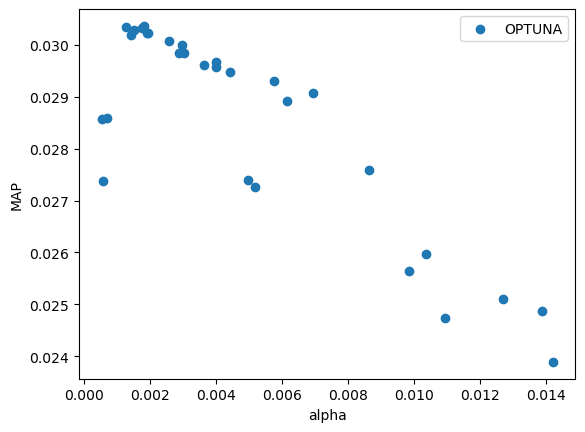

In [21]:
import matplotlib.pyplot as pyplot
%matplotlib inline  

pyplot.scatter(opt_df["params_alpha"].values, opt_df["value"].values, label="OPTUNA")
#pyplot.plot(MAP_per_shrinkage_rnd["shrink"].values, MAP_per_shrinkage_rnd["MAP"].values, label="Rnd")
pyplot.ylabel('MAP')
pyplot.xlabel('alpha')
pyplot.legend()
pyplot.show()

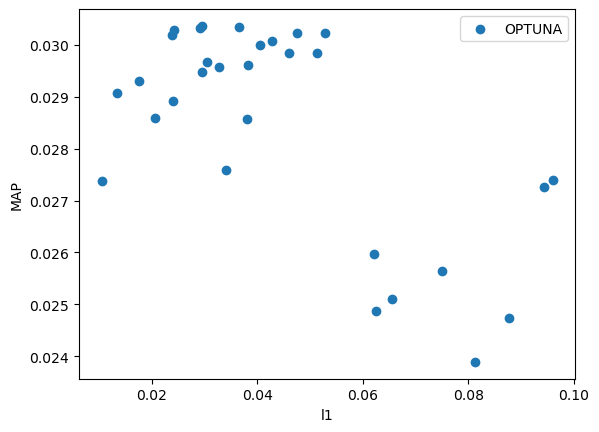

In [22]:
import matplotlib.pyplot as pyplot
%matplotlib inline  

pyplot.scatter(opt_df["params_l1_ratio"].values, opt_df["value"].values, label="OPTUNA")
#pyplot.plot(MAP_per_shrinkage_rnd["shrink"].values, MAP_per_shrinkage_rnd["MAP"].values, label="Rnd")
pyplot.ylabel('MAP')
pyplot.xlabel('l1')
pyplot.legend()
pyplot.show()

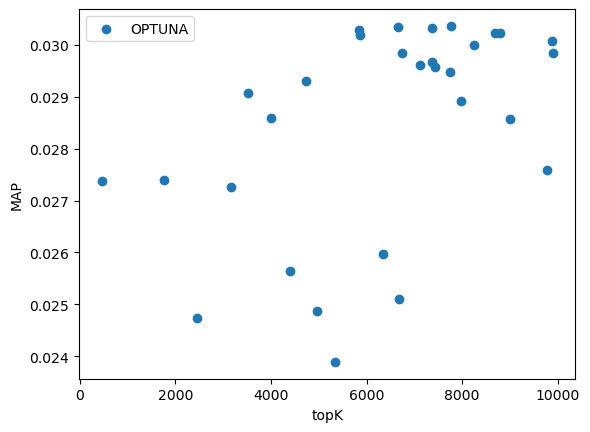

In [23]:
import matplotlib.pyplot as pyplot
%matplotlib inline  

pyplot.scatter(opt_df["params_topK"].values, opt_df["value"].values, label="OPTUNA")
#pyplot.plot(MAP_per_shrinkage_rnd["shrink"].values, MAP_per_shrinkage_rnd["MAP"].values, label="Rnd")
pyplot.ylabel('MAP')
pyplot.xlabel('topK')
pyplot.legend()
pyplot.show()